In [2]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
df = pd.read_csv('AirlineTweets.csv')

In [6]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df = df[['airline_sentiment', 'text']]

<Axes: >

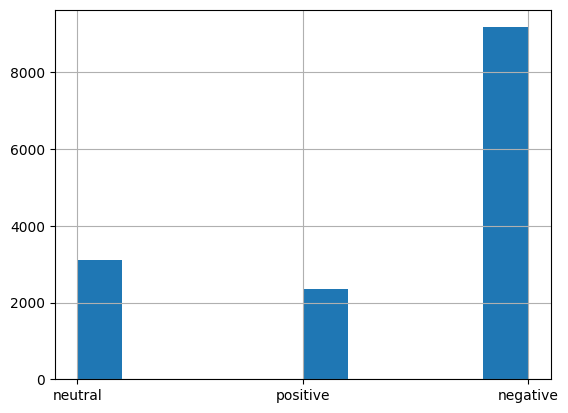

In [9]:
df['airline_sentiment'].hist()

In [10]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [13]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [14]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [15]:
df_train, df_test = train_test_split(df, random_state=42)

In [16]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [17]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [18]:
Y_train = df_train['target']
Y_test = df_test['target']

In [19]:
# input dimensions
D = X_train.shape[1]

In [23]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model = Model(i, x)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [26]:
r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
68/68 [==============================] - 2s 12ms/step - loss: 0.5042 - accuracy: 0.7920 - val_loss: 0.3971 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 0s 7ms/step - loss: 0.3755 - accuracy: 0.7972 - val_loss: 0.3390 - val_accuracy: 0.8205
Epoch 3/40
68/68 [==============================] - 0s 6ms/step - loss: 0.3220 - accuracy: 0.8194 - val_loss: 0.3025 - val_accuracy: 0.8416
Epoch 4/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2849 - accuracy: 0.8447 - val_loss: 0.2767 - val_accuracy: 0.8600
Epoch 5/40
68/68 [==============================] - 1s 8ms/step - loss: 0.2575 - accuracy: 0.8640 - val_loss: 0.2580 - val_accuracy: 0.8773
Epoch 6/40
68/68 [==============================] - 1s 8ms/step - loss: 0.2366 - accuracy: 0.8816 - val_loss: 0.2443 - val_accuracy: 0.8895
Epoch 7/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2202 - accuracy: 0.8921 - val_loss: 0.2335 - val_accuracy: 0.8992
Epoch 8/40
68/68 [=

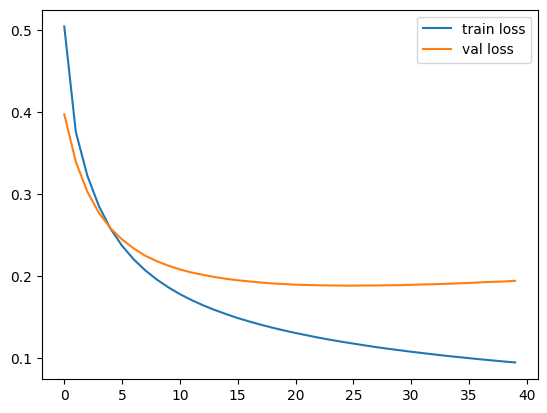

In [27]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

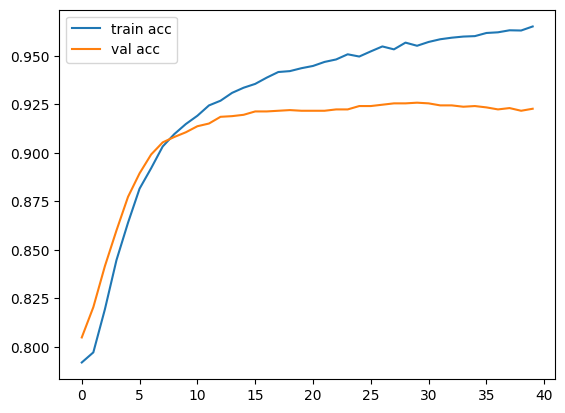

In [28]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [35]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 1ms/step


In [36]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99110139, 0.00889861],
       [0.09833333, 0.90166667]])

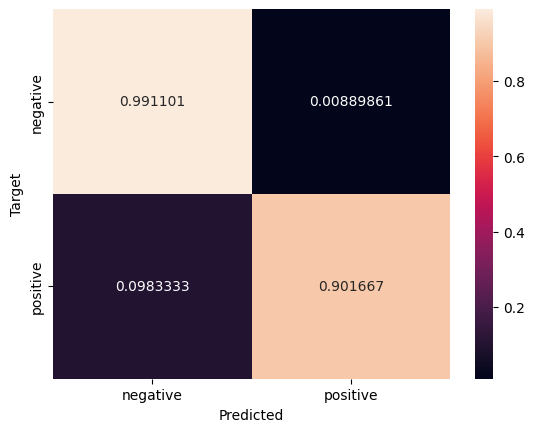

In [37]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

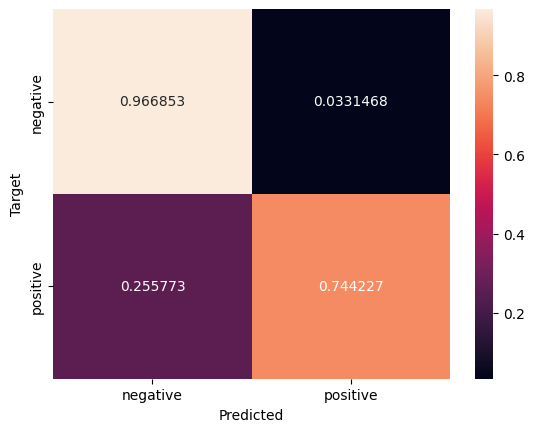

In [38]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [46]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

91/91 [==============================] - 0s 1ms/step
Train AUC: 0.9950042142799255
Test AUC: 0.9547982985803407


In [47]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9316877152698048
Test F1: 0.7913125590179414


In [48]:
model.layers

In [57]:
model.layers[1].get_weights()

[array([[-3.7285228],
        [ 3.2972553],
        [-1.5671529],
        ...,
        [ 2.0742311],
        [ 1.6022604],
        [-2.9235682]], dtype=float32),
 array([-0.2528696], dtype=float32)]

In [58]:
w = model.layers[1].get_weights()[0]

In [62]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [66]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.7794485
thanks 9.393036
worries 8.428569
great 7.907656
awesome 7.3824105
love 7.2546744
excellent 7.138132
kudos 6.7177296
amazing 6.450351
best 6.1176934


In [67]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most negative words:
worst -9.343755
paid -7.7034035
not -7.6083913
rude -7.5843096
disappointed -7.2247424
nothing -6.8142147
website -6.7868724
hung -6.7018967
instead -6.575118
list -6.213312


In [ ]:
# Exercise: apply to spam detection